In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.image import imread 
import seaborn as sns

from tqdm.auto import tqdm

from colorama import Fore, Style, init
from PIL import Image
from os import listdir
from pathlib import Path

pd.options.mode.chained_assignment = None

%matplotlib inline


C:\Users\123\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
BASE_DIR = Path('')
#'/kaggle/input/blood-vessel-segmentation'
train_df = pd.read_csv(BASE_DIR / 'train_rles.csv')

In [3]:
##

## Functions

In [4]:
def show_train_count_data(train_df):
    df_mask_empty =  train_df.groupby('data_set')['mask_is_empty'].value_counts(normalize=True) * 100
    df_mask_empty = df_mask_empty.rename('percent').reset_index()
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(13,10))


    sns.barplot(y="kidney", x="type",  
            data= pd.DataFrame(train_df[['data_set','kidney','type','rle']].groupby(['kidney'])['type'].count()).reset_index(), 
          ax = ax[0,0]);
    for patch in ax[0,0].patches:
    # Variables
        height = patch.get_height() 
        width = patch.get_width()
        percent = 100*width/len(train_df)
        y_pos = patch.get_y()
        text = f'{width} ({percent:.1f}%)'
        ax[0,0].text(width,  y_pos + height/2, text)
    ax[0,0].set_xlabel('count')
    ax[0,0].set_ylabel('')
    ax[0,0].set_title("Аmount of data in folders kidney")


    pd.DataFrame(train_df[['data_set', 'kidney','type','rle']]\
             .groupby(['kidney'])['type'].count()).reset_index().set_index('kidney')\
            .plot.pie(y='type', autopct='%.1f%%', legend=False, ax = ax[0,1])
    ax[0,1].set_title("Аmount of data in folders kidney")
    plt.ylabel('');
    plt.xlabel('');


    sns.countplot(data = train_df, y = 'data_set',  palette="deep", ax = ax[1,0])
    for patch in ax[1,0].patches:
    # Variables
        height = patch.get_height()
        width = patch.get_width()
        percent = 100*width/len(train_df)
        y_pos = patch.get_y()
        text = f'{int(width)} ({percent:.1f}%)'
        ax[1,0].text(width ,  y_pos + height/2, text)
    ax[1,0].set_xlabel('count')
    ax[1,0].set_ylabel('')
    ax[1,0].set_title("Аmount of data in each folder")


    sns.barplot(data = df_mask_empty , x = 'percent',
              y = 'data_set',  hue = 'mask_is_empty', palette="deep" , ax = ax[1,1]);
    ax[1,1].legend(bbox_to_anchor=(1.02, 0.3), loc='center left')
    ax[1,1].set_ylabel('')
    ax[1,1].set_title("Percentage of empty images in each folder")

    for patch in ax[1,1].patches:
        height = patch.get_height() 
        y_loc = patch.get_y()
        width = patch.get_width()
        if width == 0:
            continue

        ax[1,1].text(width, y_loc + height/2, f'{width:.1f}%')
    plt.subplots_adjust(wspace = 0.6, hspace = 0.3);
    plt.show();

## Анализ обучающей выборки
**Число картинок в обучающей выборке**

In [5]:
train_df.shape[0]

7429

In [6]:
train_df['data_set'] = train_df['id'].map(lambda x: x[:-5] )
train_df['kidney'] = train_df['id'].map(lambda x: '_'.join(x.split('_')[:2] ))
train_df['type'] = train_df['id'].map(lambda x: x.split('_')[2] if '_'.join(x.split('_')[:2]) != 'kidney_2' else '')
train_df['img_name'] = train_df['id'].map(lambda x: x.split('_')[-1] )
train_df['mask_is_empty'] = train_df['rle'] == '1 0'



C:\Users\123\AppData\Local\Temp\ipykernel_16660\362943632.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data = train_df, y = 'data_set',  palette="deep", ax = ax[1,0])


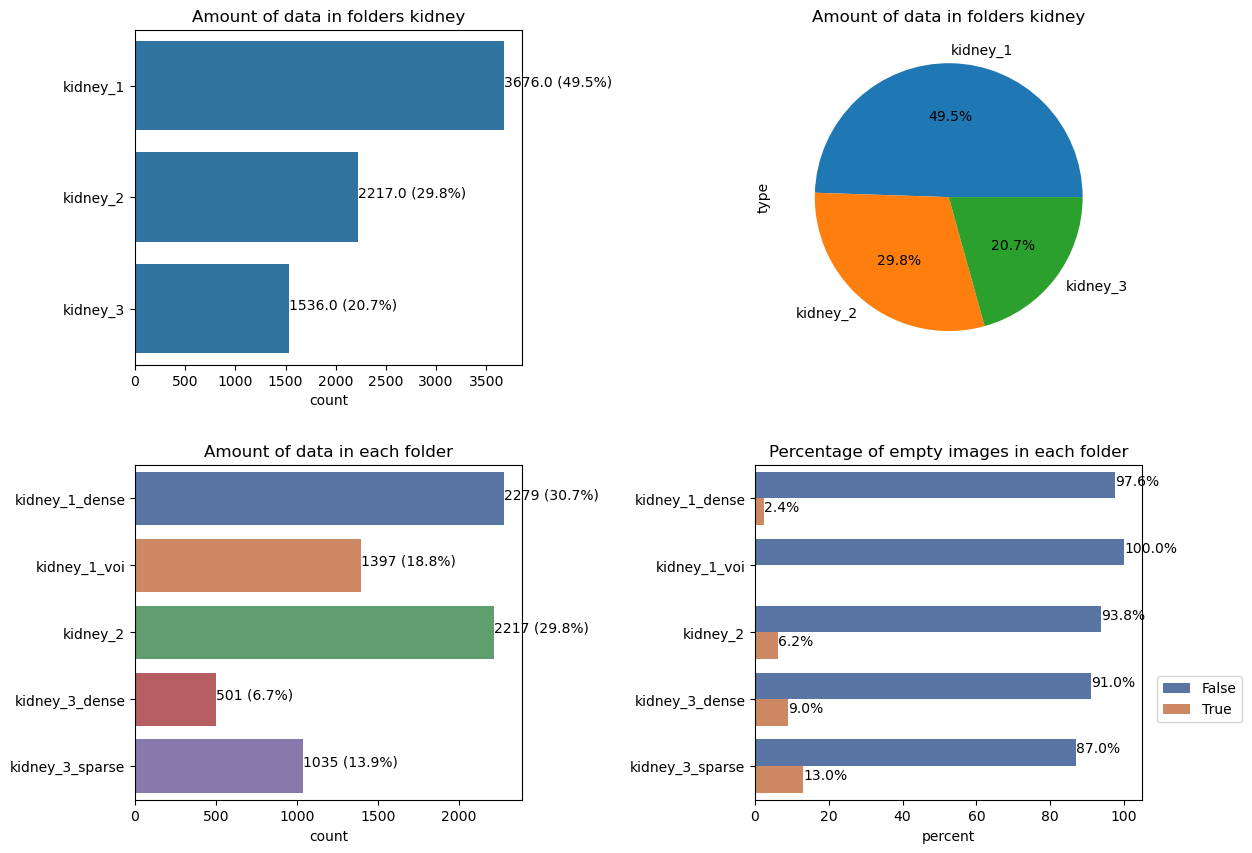

In [7]:
show_train_count_data(train_df)   

## Let's look at the sizes of the pictures in each folder

In [8]:
def subset_df(train_df, base_dir, im_dir='kidney_1_dense',lb_dir='kidney_1_dense'):

    
    micro_df = train_df[train_df['id'].str.startswith(lb_dir)]
    
    micro_df['images'] = micro_df['img_name'].map(lambda x: base_dir / im_dir / 'images' / f'{x}.tif')
    micro_df['labels'] = micro_df['img_name'].map(lambda x: base_dir / lb_dir / 'labels' / f'{x}.tif')

    return micro_df


In [9]:
kidney_1 = subset_df(train_df, base_dir = BASE_DIR / 'train', im_dir='kidney_1_dense',lb_dir='kidney_1_dense')

In [10]:
kidney_1['images_width'] = kidney_1['images'].map(lambda x: Image.open(x).size[0])
kidney_1['images_height'] = kidney_1['images'].map(lambda x: Image.open(x).size[1])

kidney_1['labels_width'] = kidney_1['labels'].map(lambda x: Image.open(x).size[0])
kidney_1['labels_height'] = kidney_1['labels'].map(lambda x: Image.open(x).size[1])

In [11]:
kidney_1[['images_width', 'images_height', 'labels_width', 'labels_height', 'images_height', ]].apply(['unique'])

,images_width,images_height,labels_width,labels_height,images_height
unique,[912],[1303],[912],[1303],[1303]


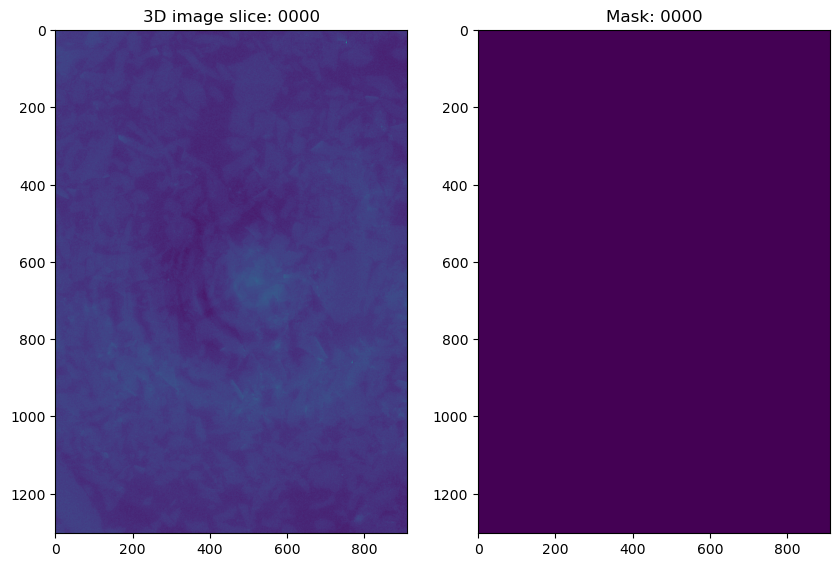

In [12]:
fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
img_name = kidney_1['img_name'][0]
img = imread(kidney_1['images'][0])
label = imread(kidney_1['labels'][0])
ax1.set_title(f'3D image slice: {img_name}')
ax1.imshow(img)


ax2.set_title(f'Mask: {img_name}')
ax2.imshow(label)
plt.show()


In [13]:
def animate(mini_df, id_range):

    images = []
    fig, [ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    ax1.axis('off')
    ax2.axis('off')
    for i in tqdm(id_range):

        

        
        img_name = mini_df['img_name'][i]
        image = imread(mini_df['images'][i])
        label = imread(mini_df['labels'][i])
        im1 = ax1.imshow(image, animated=True)
        im2 = ax2.imshow(label, animated=True)
        if i==0:
            ax1.imshow(image)
            ax2.imshow(label)
        images.append([im1,im2])


    ani = animation.ArtistAnimation(fig, images, interval=1, blit=True,
                                    repeat_delay=1000)
    plt.close()
    return ani

In [32]:
from IPython.display import HTML
def animate1(sample_df,id_range):
    fig, [ax1,ax2] = plt.subplots(1,2)
    ax1.axis('off')
    ax2.axis('off')
    images = []
    for i in tqdm(id_range):
        #print(i)
        img_name = sample_df['img_name'][i]
        image = imread(sample_df['images'][i])
        label = imread(sample_df['labels'][i])
        ax1.set_title(f'3D image slice: {img_name}')
        im1 = ax1.imshow(image, animated=True)
        ax2.set_title(f'Mask: {img_name}')
        im2 = ax2.imshow(label, animated=True)
        if i==0:
            #ax1.set_title(f'3D image slice: {img_name}')
            ax1.imshow(image)
            #ax1.set_title(f'Mask: {img_name}')
            ax2.imshow(label)
        images.append([im1,im2])


    ani = animation.ArtistAnimation(fig, images, interval=50, blit=True,
                                    repeat_delay=1000)
    plt.close()
    display(HTML(ani.to_jshtml()))
    #return ani

In [ ]:
animate1(kidney_1, range(0,500))

  0%|          | 0/500 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\animation.py:887: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


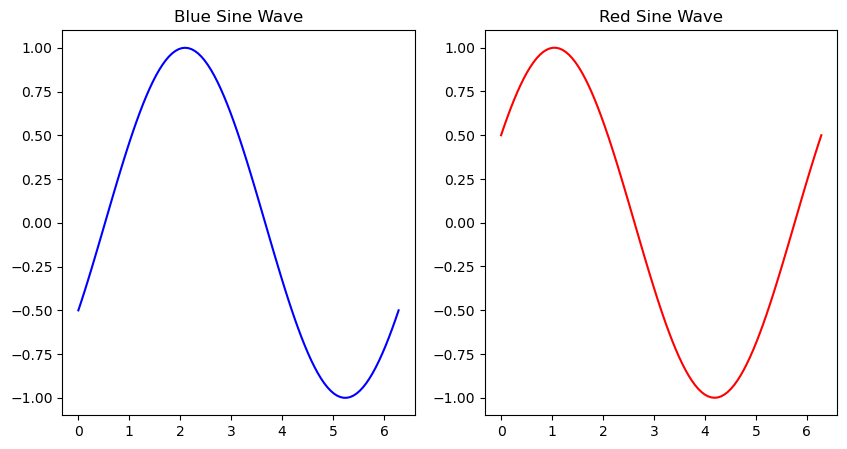

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
def animate(i):
    # Clear the subplots before adding new data
    axs[0].cla()
    axs[1].cla()

    # Generate x values for the sine wave
    x = np.linspace(0, 2 * np.pi, 100)

    # Calculate y values for the sine wave, using a sine function with different phases
    y1 = np.sin(x + np.pi / 6 * i)
    y2 = np.sin(x - np.pi / 6 * i)

    # Add the sine waves to the subplots
    axs[0].plot(x, y1, color='blue')
    axs[1].plot(x, y2, color='red')

    # Set the title for each subplot
    axs[0].set_title('Blue Sine Wave')
    axs[1].set_title('Red Sine Wave')

# Create the animation
ani = animation.ArtistAnimation(fig, [animate(i) for i in range(12)], interval=200)

# Display the animation
plt.show()

<Figure size 1000x500 with 0 Axes>

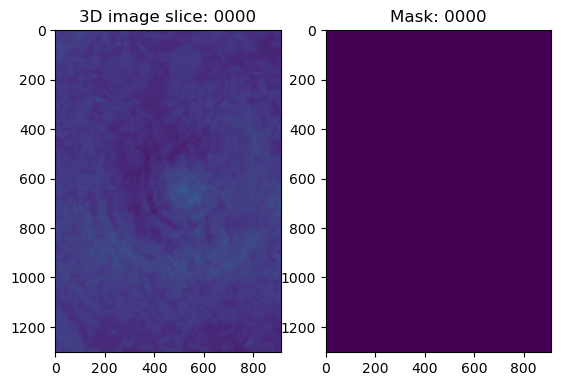

In [60]:
plt.figure(figsize=(10, 5))
fig, [ax1,ax2] = plt.subplots(1,2)

img_name = kidney_1['img_name'][0]
img = imread(kidney_1['images'][0])
label = imread(kidney_1['labels'][0])
ax1.set_title(f'3D image slice: {img_name}')
ax1.imshow(img)

plt.subplot(1, 2, 2)
ax2.set_title(f'Mask: {img_name}')
ax2.imshow(label)
plt.show()

In [32]:
kidney_1['labels'][0]

WindowsPath('train/kidney_1_dense/labels/0000.tif')